In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.python.data import Dataset
import db
import sys
import pymongo
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras import initializers
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
from IPython.core.interactiveshell import InteractiveShell
from tensorflow.python.keras.models import load_model
InteractiveShell.ast_node_interactivity = "all"

myclient = pymongo.MongoClient("mongodb://localhost:27017/")
transferdb = myclient["transferdb"]

collfalse = transferdb["synfalse_transfers"]
colltrue = transferdb["true_transfers"]
colltrue_test = transferdb["true_test_transfers"]
collfalse_test = transferdb["synfalse_test_transfers"]

# df_true = pd.read_json("./true_transfers.json", lines=True)
# df_false = pd.read_json("./false.json", lines=True)


df_false = pd.DataFrame(list(collfalse.find()))
df_true = pd.DataFrame(list(colltrue.find()))


# df_true_test = pd.read_json("./true_test.json", lines=True)
# df_false_test = pd.read_json("./false_test.json", lines=True)
df_true_test = pd.DataFrame(list(colltrue_test.find()))
df_false_test = pd.DataFrame(list(collfalse_test.find()))



# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

In [2]:



def preprocess_features(df):
    selected_features = df["tweet_text"].tolist()
    return selected_features

def preprocess_targets(df):
    output_targets = pd.DataFrame()
    output_targets["label_int"] = (df["label"] == "True").astype(float)
    return output_targets["label_int"].tolist()
    

    
    

In [3]:
# making the training sets
shuffeled_true = df_true.sample(frac=1)
shuffeled_false = df_false.sample(frac=1)
shuffeled = pd.concat([shuffeled_true.head(50000), shuffeled_false]).sample(frac=1)
training_examples = preprocess_features(shuffeled.head(80000))
training_targets = preprocess_targets(shuffeled.head(80000))

validation_examples = preprocess_features(shuffeled.tail(18000))
validation_targets = preprocess_targets(shuffeled.tail(18000))

shuffeled_true_test = df_true_test.sample(frac=1)
shuffeled_false_test = df_false_test.sample(frac=1)
shuffeled_test = pd.concat([shuffeled_true_test, shuffeled_false_test]).sample(frac=1)
test_examples = preprocess_features(shuffeled_test.head(8000))
test_targets = preprocess_targets(shuffeled_test.head(8000))




In [4]:


print("Training examples summary:")
display.display(training_examples)
print("Validation examples summary:")
display.display(validation_examples)

print("Training targets summary:")
display.display(training_targets)
print("Validation targets summary:")
display.display(validation_targets)

print("Test examples summary:")
display.display(test_examples)
print("Test targets summary:")
display.display(test_targets)



Training examples summary:


[u'Wayne Rooney WILL sign for Everton by the end of the week. (Sun Sport)',
 u"Looks like the managerial saga at Chelsea will finally be sorted out as reports of Antonio Conte's sacking have emerged. Napoli manager Maurizio Sarri looks certain to take over at Stamford Bridge, as the Blues also appear close to signing midfielder Jorginho . #CFC #PLonNBC",
 u'Chelsea making \xa340mill bid for Cavani . Under Mourinho he will be a fucking animal, sign him up Jose #CFC',
 u'Diogo Dalot to Manchester United na done deal \u2013 Craig\xa0Norwood http:// manutdinpidgin.com/2018/06/05/dio go-dalot-to-manchester-united-na-done-deal-craig-norwood/ \u2026 pic.twitter.com/jRmqREO3bx',
 u"@leedchandler82 if Arsenal sign Benzema I hate to think what'll happen. Still think Chelsea will win it at this stage",
 u'Manchester City transfer news: Pep Guardiola to raid Barcelona for Claudio Bravo, John Stones and Nolito double\u2026 http:// beitrag.news4sport.de/?p=548735',
 u'Reports: Roma and Liverpool Clo

Validation examples summary:


[u'Sky Sources: Huddersfield Town are interested in signing Monaco striker Adama Diakhaby . #htafc',
 u'#Leicester City #transfer news Eldin Jakupovic to have Hong Kong | Leicester Mercury #LCFC http://www. football-addict.com/article/leices ter-city-fc/leicestermercury/596ca0b2473524682f4ecc2d/leicester-city-transfer-news-eldin-jakupovic-to-have-hong-kong?lang=en&utm_campaign=post-auto&utm_medium=twitter&utm_source=foxes-addict-en \u2026',
 u'Alex oxlade chamberlain will not sign for Liverpool this summer. He Will stay at arsenal and sign a new contract. #AFC',
 u'Shaqiri to go and Watford signing Will Hughes for a bargain...this Summer really is going well at the moment. #SCFC',
 u'@DiMarzio : Napoli is trying to get David Ospina from Arsenal on loan with option but Gunners wants to sell him. Talks ongoing. #AFC pic.twitter.com/sZUjLUWOYz',
 u'Real Madrid offer Gareth Bale bumper new contract to ward off Manchester United transfer \u2026 http:// dlvr.it/LhBZ1Y pic.twitter.com/achatG1

Training targets summary:


[1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0

Validation targets summary:


[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0

Test examples summary:


[u'HHTV SPORTS NEWS Why Angel Di Maria Is Not the Right Signing for Paris Saint - Germain This Summer http:// ow.ly/2WIMwx',
 u'Leicester City great Emile Heskey tells Jamie Vardy to reject Arsenal transfer http:// dlvr.it/LcXN05',
 u'Pedro is on the verge of signing for Chelsea after Man Utd pulled out of the deal yesterday. #cfc #mufc',
 u'Manchester City close in on Patrick Roberts move as Fulham youngster arrives for medical to complete \xa38m transfer http:// dailym.ai/1fdFWG4',
 u'Signing Jamie Vardy is a risk worth taking for Arsenal http:// dlvr.it/LTcg7s pic.twitter.com/TT09ZOUziS',
 u'Liverpool confirm agreement on Raheem Sterling transfer to Manchester City http:// dlvr.it/BW5rLt pic.twitter.com/LlqQypKqop',
 u'Arsenal signed Vardy , next season will be lit. RT @sidin : One day Ozil will play in a team that has strikers.',
 u'Sunderland ?close to completing transfer of Rubin Kazan midfielder Yann M?Vila ? http:// bit.ly/1gwWsST',
 u'Sky Sports: Robin van Persie tomorrow will

Test targets summary:


[1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0

In [5]:
def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [6]:
ndarr = np.array(training_targets)


x_train, x_val = ngram_vectorize(training_examples, training_targets, validation_examples)
print(x_val)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:1577: UserWarning: Only (<type 'numpy.float64'>, <type 'numpy.float32'>, <type 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


  (0, 1117)	0.2608794
  (0, 1923)	0.097518064
  (0, 1944)	0.19718592
  (0, 8504)	0.23611355
  (0, 8659)	0.18164657
  (0, 8661)	0.18326545
  (0, 8848)	0.07856535
  (0, 8936)	0.18097983
  (0, 9045)	0.16709611
  (0, 9047)	0.17121059
  (0, 11768)	0.15911987
  (0, 15740)	0.08628198
  (0, 15819)	0.24485697
  (0, 15913)	0.14180589
  (0, 15917)	0.17388222
  (0, 16058)	0.14242771
  (0, 16417)	0.12397762
  (0, 17871)	0.1748706
  (0, 17873)	0.2356156
  (1, 1127)	0.16762279
  (1, 1128)	0.083811395
  (1, 1129)	0.08538676
  (1, 2187)	0.06851004
  (1, 2193)	0.118260324
  (1, 2445)	0.08445145
  :	:
  (17999, 3307)	0.14618331
  (17999, 3327)	0.27737308
  (17999, 4076)	0.07249085
  (17999, 4091)	0.167535
  (17999, 4298)	0.09676853
  (17999, 4393)	0.17235082
  (17999, 5545)	0.10590871
  (17999, 5546)	0.105913065
  (17999, 7258)	0.2537733
  (17999, 7259)	0.2537733
  (17999, 8508)	0.05046801
  (17999, 8529)	0.10783989
  (17999, 9185)	0.09528769
  (17999, 10104)	0.16325717
  (17999, 10105)	0.16362
  (17999,

In [7]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [8]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model


In [9]:
def plot_res(history):
    
    plt.ylabel("Accuracy")
    plt.xlabel("Periods")
    plt.title("Training & Validation Accuracy")
    plt.tight_layout()
    plt.plot(history['acc'], label="training")
    plt.plot(history['val_acc'], label="validation")
    plt.legend()
    plt.show()
    
    

In [10]:
def plot_loss(history):
    plt.ylabel("Loss")
    plt.xlabel("Periods")
    plt.title("Training & Validation Loss")
    plt.tight_layout()
    plt.plot(history['loss'], label="training")
    plt.plot(history['val_loss'], label="validation")
    plt.legend()
    plt.show()
    

In [11]:
def calculate_auc(history):
    auc = metrics.roc_auc_score(validation_targets[0:len(history["val_acc"])], history['val_acc'])
    return auc
    

In [12]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=6,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
#     num_classes = explore_data.get_num_classes(train_labels)
    num_classes = 2
#     unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
#     if len(unexpected_labels):
#         raise ValueError('Unexpected label values found in the validation set:'
#                          ' {unexpected_labels}. Please make sure that the '
#                          'labels in the validation set are in the same range '
#                          'as training labels.'.format(
#                              unexpected_labels=unexpected_labels))

    # Vectorize texts.
    ndarr = np.array(train_labels)
    x_train, x_val = ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
#     print('Validation accuracy: {acc}, loss: {loss}'.format(
#             acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    
    # Compute training and validation loss.
    
    # Plot Results
    plot_res(history)
    roc_curve(history)
    plot_loss(history)
    # Save model.
    model.save('twitter_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

Train on 80000 samples, validate on 18000 samples
Epoch 1/10
 - 28s - loss: 0.4410 - acc: 0.8375 - val_loss: 0.1873 - val_acc: 0.9820
Epoch 2/10
 - 26s - loss: 0.2745 - acc: 0.9125 - val_loss: 0.1242 - val_acc: 0.9853
Epoch 3/10
 - 26s - loss: 0.2505 - acc: 0.9168 - val_loss: 0.1067 - val_acc: 0.9863
Epoch 4/10
 - 21s - loss: 0.2415 - acc: 0.9211 - val_loss: 0.1013 - val_acc: 0.9869
Epoch 5/10
 - 25s - loss: 0.2439 - acc: 0.9201 - val_loss: 0.1027 - val_acc: 0.9876
Epoch 6/10
 - 21s - loss: 0.2370 - acc: 0.9219 - val_loss: 0.1015 - val_acc: 0.9879
Epoch 7/10
 - 23s - loss: 0.2369 - acc: 0.9227 - val_loss: 0.1007 - val_acc: 0.9876
Epoch 8/10
 - 24s - loss: 0.2385 - acc: 0.9218 - val_loss: 0.0986 - val_acc: 0.9874
Epoch 9/10
 - 24s - loss: 0.2379 - acc: 0.9214 - val_loss: 0.0991 - val_acc: 0.9877
Epoch 10/10
 - 22s - loss: 0.2366 - acc: 0.9216 - val_loss: 0.1004 - val_acc: 0.9878


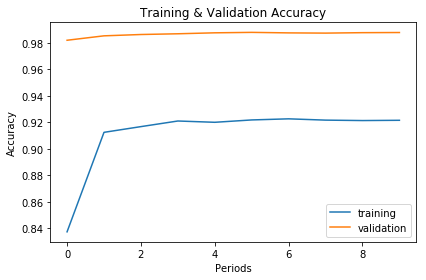

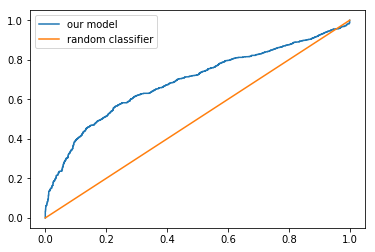

AUC
0.6898457809595493


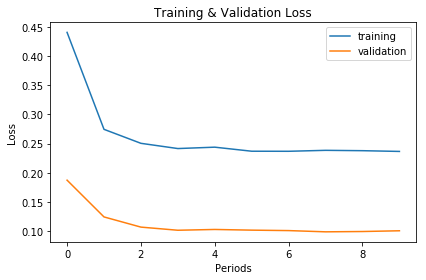

(0.9878333, 0.1004137060377333)

In [94]:
data = (training_examples, training_targets),(validation_examples, validation_targets)
train_ngram_model(data,
                      learning_rate=0.001,
                      epochs=10,
                      batch_size=64,
                      layers=4,
                      units=4,
                      dropout_rate=0.4)


In [13]:
def make_prediction(tweet_text):
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
#     print(tweet_text)
    x_train, x_val = ngram_vectorize(
        training_examples, training_targets, tweet_text)
    fake_detector = load_model('twitter_model.h5')
    prediction = fake_detector.predict(x_val)
    print(prediction)

In [14]:
def evaluate_model():
    x_train, test_set = ngram_vectorize(training_examples, training_targets, test_examples)
#     x_train, test_labels = ngram_vectorize(training_examples, training_targets, test_targets)
    fake_detector = load_model('twitter_model.h5')
    prediction = fake_detector.evaluate(test_set, test_targets)
    
    

In [15]:
def roc_curve(history):
    x_train, test_set = ngram_vectorize(training_examples, training_targets, test_examples)
    fake_detector = load_model('twitter_model.h5')
    prediction = fake_detector.predict(test_set)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_targets, prediction)
    plt.plot(false_positive_rate, true_positive_rate, label="our model")
    plt.plot([0, 1], [0, 1], label="random classifier")
    _ = plt.legend(loc=2)
    plt.show()
    auc = metrics.roc_auc_score(test_targets,prediction)
    print("AUC")
    print(auc)

In [95]:
evaluate_model()

8000/8000 [==============================] - 2s 293us/sample - loss: 1.2893 - acc: 0.8173


In [ ]:
# SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK 

In [17]:
def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

In [18]:
def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

In [23]:
def evaluate_seq_model():
    x_train, test_set = sequence_vectorize(training_examples, training_targets, test_examples)
    fake_detector = load_model('twitter_model_seq.h5')
    prediction = fake_detector.evaluate(test_set, test_targets)

In [20]:
def train_seq_model(data,
                      learning_rate,
                      epochs,
                      batch_size,
                      layers,
                      units,
                      dropout_rate):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
#     num_classes = explore_data.get_num_classes(train_labels)
    num_classes = 2
#     unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
#     if len(unexpected_labels):
#         raise ValueError('Unexpected label values found in the validation set:'
#                          ' {unexpected_labels}. Please make sure that the '
#                          'labels in the validation set are in the same range '
#                          'as training labels.'.format(
#                              unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val, word_index = sequence_vectorize(
        train_texts, val_texts)
    print(x_train.shape)
    print(x_val.shape)
    
    # Create model instance.
    model = sepcnn_model(blocks=layers, filters=4, kernel_size=4, embedding_dim=200, dropout_rate=dropout_rate, pool_size=3, input_shape=x_train.shape[1:], 
                         num_classes=2, num_features=TOP_K)
    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=6)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
#     print('Validation accuracy: {acc}, loss: {loss}'.format(
#             acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    
    # Compute training and validation loss.
    
    # Plot Results
    plot_res(history)
    roc_curve(history)
    plot_loss(history)
    
    # Save model.
    model.save('twitter_model_seq.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

(80000, 94)
(18000, 94)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 80000 samples, validate on 18000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 - 108s - loss: 0.6945 - acc: 0.5001 - val_loss: 0.6934 - val_acc: 0.5033
Epoch 2/20
 - 122s - loss: 0.6943 - acc: 0.5034 - val_loss: 0.6946 - val_acc: 0.5033
Epoch 3/20
 - 120s - loss: 0.6945 - acc: 0.5000 - val_loss: 0.6935 - val_acc: 0.4967
Epoch 4/20
 - 127s - loss: 0.6946 - acc: 0.4981 - val_loss: 0.6931 - val_acc: 0.4967
Epoch 5/20
 - 126s - loss: 0.6949 - acc: 0.4969 - val_loss: 0.6932 - val_acc: 0.5033
Epoch 6/20
 - 126s - loss: 0.6946 - acc: 0.4996 - val_loss: 0.6938 - val_acc: 0.5033
Epoch 7/20
 - 123s - loss: 0.6949 - acc: 0.5017 - val_loss: 0.6933 - val_acc: 0.4967
Epoch 8/20
 - 117s - loss: 0.6946 - acc: 0.5018 - val_loss: 0.6932 - val_acc: 0.5033
Epoch 9/20


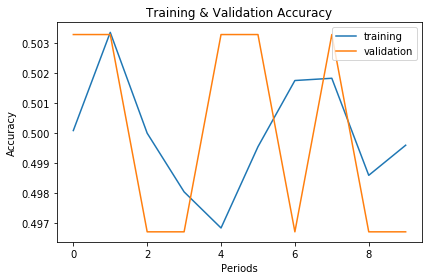

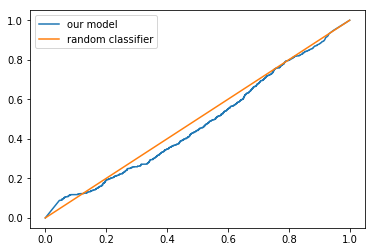

AUC
0.4767078644846659


(0.49672222, 0.7009970130390591, 0.380952380952381)

In [21]:
data = (training_examples, training_targets),(validation_examples, validation_targets)
train_seq_model(data=data,
                      learning_rate=0.01,
                      epochs=10,
                      batch_size=64,
                      layers=2,
                      units=1,
                      dropout_rate=0.2)

In [22]:
evaluate_seq_model()

ValueError: too many values to unpack